# Spatial Hotspot Analysis - Crime Clustering

This notebook implements the primary clustering analysis for geographic crime hotspot identification. Using density-based and partitioning algorithms, we identify spatial crime concentration patterns in NYC data.

---

# 1. Setup

This section handles the initial setup, including importing necessary libraries, defining file paths, and configuring the environment for spatial clustering analysis. Custom transformers for spatial feature engineering are imported from our utilities module.

## Optional: Google Colab Setup

Uncomment and run this cell if working in Google Colab environment.

In [33]:
# Run on Google Colab (optional)
# from google.colab import drive
# drive.mount('/drive', force_remount=True)

## Import Libraries

Import all libraries required for spatial clustering analysis, pipeline construction, and geographic visualization.

In [34]:
# Core data manipulation and computation
import pandas as pd
import numpy as np
import os
import sys
import warnings
import joblib
import json
import time
import math
from statistics import mean

# Shapely and geographic projection
from shapely.geometry import Point, MultiPoint, mapping
from shapely.ops import transform as shp_transform
from pyproj import Transformer

# Machine learning and clustering
from sklearn.base import clone
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.cluster import DBSCAN
from sklearn.model_selection import ParameterGrid
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_score

# Visualization libraries
import matplotlib.pyplot as plt

# custom transformers
from Utilities.clustering_transformers import SpatialProjectionTransformer, CyclicalTransformer

# Geographic and mapping libraries
try:
    import folium
    from folium import plugins, FeatureGroup, GeoJson
    FOLIUM_AVAILABLE = True
except ImportError:
    print("Folium not available. Map visualizations will be limited.")
    FOLIUM_AVAILABLE = False

# Configure plotting
plt.style.use('default')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10
warnings.filterwarnings('ignore')

## Configure Paths and Custom Utilities

Set up file paths and import custom clustering utilities.

In [35]:
# Configure working directory and paths
current_dir = os.getcwd()
project_root = os.path.abspath(os.path.join(current_dir, '../..'))
data_dir = os.path.join(project_root, 'Data')
output_dir = os.path.join(project_root, 'JupyterOutputs', 'Clustering')
models_dir = os.path.join(output_dir, 'models')

# Create output directories if they don't exist
os.makedirs(output_dir, exist_ok=True)
os.makedirs(models_dir, exist_ok=True)

print(f"Project root: {project_root}")
print(f"Data directory: {data_dir}")
print(f"Output directory: {output_dir}")
print(f"Models directory: {models_dir}")

# Add utilities to Python path
utilities_path = os.path.join(os.getcwd(), 'Utilities')
if utilities_path not in sys.path:
    sys.path.append(utilities_path)

Project root: c:\UNIVERSITA MAG\Data mining and Machine learning\Progetto\crime-analyzer
Data directory: c:\UNIVERSITA MAG\Data mining and Machine learning\Progetto\crime-analyzer\Data
Output directory: c:\UNIVERSITA MAG\Data mining and Machine learning\Progetto\crime-analyzer\JupyterOutputs\Clustering
Models directory: c:\UNIVERSITA MAG\Data mining and Machine learning\Progetto\crime-analyzer\JupyterOutputs\Clustering\models


## Configure Analysis Parameters

Define key parameters for the clustering analysis.

In [36]:
# Random state for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Feature columns for spatial analysis (aligned with actual dataset)
SPATIAL_FEATURES = ['Latitude', 'Longitude']

# Primary temporal features for clustering
TEMPORAL_FEATURES = ['HOUR', 'WEEKDAY', 'MONTH']

# Extended temporal features available in dataset
EXTENDED_TEMPORAL_FEATURES = [
    'HOUR', 'DAY', 'WEEKDAY', 'IS_WEEKEND', 'MONTH', 'YEAR', 
    'SEASON', 'TIME_BUCKET', 'IS_HOLIDAY', 'IS_PAYDAY'
]

# Categorical features
CATEGORICAL_FEATURES = ['BORO_NM', 'OFNS_DESC', 'PREM_TYP_DESC']

# Extended categorical features available
EXTENDED_CATEGORICAL_FEATURES = [
    'BORO_NM', 'LAW_CAT_CD', 'LOC_OF_OCCUR_DESC', 'OFNS_DESC', 'PREM_TYP_DESC',
    'SUSP_AGE_GROUP', 'SUSP_RACE', 'SUSP_SEX', 'VIC_AGE_GROUP', 'VIC_RACE', 'VIC_SEX'
]

# Spatial context features (POI-based features for enhanced spatial analysis)
SPATIAL_CONTEXT_FEATURES = [
    'BAR_DISTANCE', 'NIGHTCLUB_DISTANCE', 'ATM_DISTANCE', 'METRO_DISTANCE',
    'MIN_POI_DISTANCE', 'AVG_POI_DISTANCE', 'MAX_POI_DISTANCE',
    'ATMS_COUNT', 'BARS_COUNT', 'BUS_STOPS_COUNT', 'METROS_COUNT', 
    'NIGHTCLUBS_COUNT', 'SCHOOLS_COUNT', 'TOTAL_POI_COUNT',
    'POI_DIVERSITY', 'POI_DENSITY_SCORE'
]

# Social features 
SOCIAL_FEATURES = ['SAME_AGE_GROUP', 'SAME_SEX']

print("Analysis parameters configured successfully!")
print(f"Primary spatial features: {SPATIAL_FEATURES}")
print(f"Primary temporal features: {TEMPORAL_FEATURES}")
print(f"Primary categorical features: {CATEGORICAL_FEATURES}")
print(f"Available spatial context features: {len(SPATIAL_CONTEXT_FEATURES)} POI-based features")
print(f"Available extended temporal features: {len(EXTENDED_TEMPORAL_FEATURES)} temporal features")

Analysis parameters configured successfully!
Primary spatial features: ['Latitude', 'Longitude']
Primary temporal features: ['HOUR', 'WEEKDAY', 'MONTH']
Primary categorical features: ['BORO_NM', 'OFNS_DESC', 'PREM_TYP_DESC']
Available spatial context features: 16 POI-based features
Available extended temporal features: 10 temporal features


---

# 2. Data Loading & Feature Preparation

This section loads the preprocessed crime dataset and prepares features specifically for spatial clustering analysis. We validate coordinate accuracy, assess feature completeness, and prepare the data for various clustering algorithms.

## Load Preprocessed Crime Dataset

Load and validate the preprocessed crime data with spatial-temporal features.

In [37]:
# Define data file path
data_file = os.path.join(data_dir, 'final_crime_data.csv')

# Check if data file exists
if not os.path.exists(data_file):
    raise FileNotFoundError(f"Data file not found: {data_file}")

print(f"Loading data from: {data_file}")

# Load the dataset
try:
    df = pd.read_csv(data_file)
    print(f"Dataset loaded successfully!")
    print(f"Shape: {df.shape}")
    print(f"Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
except Exception as e:
    raise RuntimeError(f"Error loading dataset: {e}")

# Display basic dataset information
print("\n" + "="*60)
print("DATASET OVERVIEW")
print("="*60)
print(f"Total records: {len(df):,}")
print(f"Total features: {df.shape[1]}")

Loading data from: c:\UNIVERSITA MAG\Data mining and Machine learning\Progetto\crime-analyzer\Data\final_crime_data.csv
Dataset loaded successfully!
Shape: (2493835, 44)
Memory usage: 2453.35 MB

DATASET OVERVIEW
Total records: 2,493,835
Total features: 44


## Data cleaning and Validation



In [38]:
# Validate feature availability
print("\n" + "="*60)
print("FEATURE VALIDATION")
print("="*60)

# Check spatial features
spatial_available = [col for col in SPATIAL_FEATURES if col in df.columns]
temporal_available = [col for col in TEMPORAL_FEATURES if col in df.columns]
categorical_available = [col for col in CATEGORICAL_FEATURES if col in df.columns]

print("Feature availability:")
print("-" * 30)
print(f"Spatial features: {spatial_available} ({len(spatial_available)}/{len(SPATIAL_FEATURES)})")
print(f"Temporal features: {temporal_available} ({len(temporal_available)}/{len(TEMPORAL_FEATURES)})")
print(f"Categorical features: {categorical_available} ({len(categorical_available)}/{len(CATEGORICAL_FEATURES)})")

# Apply the same temporal filter as classification test set for consistency
print(f"\n" + "="*60)
print("TEMPORAL FILTERING FOR CLUSTERING")
print("="*60)

if 'YEAR' in df.columns and 'MONTH' in df.columns:
    print(f"Original dataset years: {sorted(df['YEAR'].unique())}")
    print(f"Total records before temporal filter: {len(df):,}")
    
    # Create YearMonth for consistent filtering with classification approach
    df['YearMonth'] = df['YEAR'] * 100 + df['MONTH']
    print(f"Year-Month distribution in original dataset:")
    ym_counts = df['YearMonth'].value_counts().sort_index()
    for ym, count in ym_counts.items():
        print(f"  {ym}: {count:,} records")

    # Use the same temporal split point as classification test set (YearMonth >= 202401)
    # This corresponds to the most recent data used in classification evaluation
    test_set_start_ym = 202401  # January 2024
    print(f"\nFiltering for clustering analysis using classification test set period:")
    print(f"Using YearMonth >= {test_set_start_ym} (same as classification test set)")
    
    # Apply filter - using the classification test set period
    df_filtered = df[df['YearMonth'] >= test_set_start_ym].copy()
    
    print(f"Records after temporal filter: {len(df_filtered):,} ({(len(df_filtered)/len(df))*100:.1f}% of original)")
    
    if len(df_filtered) > 0:
        print(f"Filtered dataset year-months:")
        filtered_ym_counts = df_filtered['YearMonth'].value_counts().sort_index()
        for ym, count in filtered_ym_counts.items():
            print(f"  {ym}: {count:,} records")
        
        # Drop the temporary YearMonth column
        df_filtered.drop(columns=['YearMonth'], inplace=True)
        df.drop(columns=['YearMonth'], inplace=True)
        
        # Use filtered data for clustering
        df = df_filtered
        print(f"\nUsing filtered dataset for clustering analysis.")
        print(f"This approach ensures consistency with classification methodology")
        print(f"and focuses on the most recent crime patterns.")
    else:
        print(f"Warning: No data found for YearMonth >= {test_set_start_ym}")
        print("Falling back to recent years filter (YEAR >= 2023)")
        # Fallback to the previous approach
        recent_years_threshold = 2023
        df_filtered = df[df['YEAR'] >= recent_years_threshold].copy()
        df = df_filtered
        df.drop(columns=['YearMonth'], inplace=True)
else:
    print("Warning: YEAR or MONTH column not found. Skipping temporal filtering.")
    print("Using full dataset for clustering analysis.")

# Create clean dataset for spatial analysis
print(f"\nPreparing dataset for spatial clustering...")

# Filter for valid coordinates
if len(spatial_available) >= 2:
    # Remove rows with missing coordinates
    valid_coords_mask = df[spatial_available].notna().all(axis=1)
    df_spatial = df[valid_coords_mask].copy()
    
    print(f"Records with valid coordinates: {len(df_spatial):,} ({(len(df_spatial)/len(df))*100:.2f}%)")
    
    # Additional coordinate validation
    lat_col = 'Latitude'
    lon_col = 'Longitude'
    
    if lat_col in df_spatial.columns and lon_col in df_spatial.columns:
        # NYC coordinate bounds
        nyc_bounds_mask = (
            df_spatial[lat_col].between(40.4774, 40.9176) &
            df_spatial[lon_col].between(-74.2591, -73.7004)
        )
        df_spatial = df_spatial[nyc_bounds_mask].copy()
        
        print(f"Records within NYC bounds: {len(df_spatial):,}")
    else:
        print(f"Warning: Coordinate columns {lat_col}/{lon_col} not found for geographic filtering")
else:
    raise ValueError("Insufficient spatial features for clustering analysis")

# Display final dataset summary
print(f"\nFinal dataset for clustering:")
print(f"Shape: {df_spatial.shape}")
print(f"Coordinate coverage: {len(df_spatial):,} records")
print(f"Time range: {df_spatial['YEAR'].min()} - {df_spatial['YEAR'].max()}")
print(f"Memory usage: {df_spatial.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

# Check availability of extended features
print(f"\nExtended features availability:")
print("-" * 40)

# Check spatial context features (POI-based)
spatial_context_available = [col for col in SPATIAL_CONTEXT_FEATURES if col in df.columns]
print(f"Spatial context features: {len(spatial_context_available)}/{len(SPATIAL_CONTEXT_FEATURES)} available")
if spatial_context_available:
    print(f"  Available: {spatial_context_available[:5]}...")  # Show first 5

# Check extended temporal features
extended_temporal_available = [col for col in EXTENDED_TEMPORAL_FEATURES if col in df.columns]
print(f"Extended temporal features: {len(extended_temporal_available)}/{len(EXTENDED_TEMPORAL_FEATURES)} available")
if extended_temporal_available:
    print(f"  Available: {extended_temporal_available}")

# Check extended categorical features
extended_categorical_available = [col for col in EXTENDED_CATEGORICAL_FEATURES if col in df.columns]
print(f"Extended categorical features: {len(extended_categorical_available)}/{len(EXTENDED_CATEGORICAL_FEATURES)} available")
if extended_categorical_available:
    print(f"  Available: {extended_categorical_available[:5]}...")  # Show first 5

# Check social features
social_available = [col for col in SOCIAL_FEATURES if col in df.columns]
print(f"Social features: {len(social_available)}/{len(SOCIAL_FEATURES)} available")
if social_available:
    print(f"  Available: {social_available}")

# Display temporal distribution after filtering
if 'YEAR' in df_spatial.columns and 'MONTH' in df_spatial.columns:
    print(f"\nTemporal distribution in filtered dataset:")
    print("-" * 40)
    yearly_counts = df_spatial['YEAR'].value_counts().sort_index()
    for year, count in yearly_counts.items():
        print(f"  {year}: {count:,} records")
    
    # Show monthly distribution for each year in the filtered data
    years_in_data = sorted(df_spatial['YEAR'].unique())
    for year in years_in_data:
        monthly_counts = df_spatial[df_spatial['YEAR'] == year]['MONTH'].value_counts().sort_index()
        print(f"\nMonthly distribution for {year}:")
        print("-" * 40)
        for month, count in monthly_counts.items():
            print(f"  Month {month:2d}: {count:,} records")

# Final clustering dataset summary
print(f"\n" + "="*60)
print("CLUSTERING DATASET SUMMARY")
print("="*60)
print(f"Dataset period: Gen 2024 onwards")
print(f"Total records for clustering: {len(df_spatial):,}")
print(f"Temporal consistency: ✓ Matches classification evaluation period")
print(f"Geographic validity: ✓ NYC coordinate bounds enforced")


FEATURE VALIDATION
Feature availability:
------------------------------
Spatial features: ['Latitude', 'Longitude'] (2/2)
Temporal features: ['HOUR', 'WEEKDAY', 'MONTH'] (3/3)
Categorical features: ['BORO_NM', 'OFNS_DESC', 'PREM_TYP_DESC'] (3/3)

TEMPORAL FILTERING FOR CLUSTERING
Original dataset years: [np.int64(2020), np.int64(2021), np.int64(2022), np.int64(2023), np.int64(2024)]
Total records before temporal filter: 2,493,835
Year-Month distribution in original dataset:
  202001: 38,695 records
  202002: 35,446 records
  202003: 32,679 records
  202004: 24,907 records
  202005: 32,023 records
  202006: 32,604 records
  202007: 35,531 records
  202008: 37,524 records
  202009: 35,983 records
  202010: 37,403 records
  202011: 35,148 records
  202012: 33,516 records
  202101: 33,217 records
  202102: 28,332 records
  202103: 34,612 records
  202104: 32,619 records
  202105: 36,711 records
  202106: 37,516 records
  202107: 39,402 records
  202108: 38,945 records
  202109: 39,906 rec

In [39]:
# --- Work on a smaller sample for faster iteration ---

N_SAMPLE = 100_000  # number of rows to take

df_spatial_sample = df_spatial.sample(N_SAMPLE).copy()

print(f"Sample created: {df_spatial_sample.shape[0]} rows out of {df_spatial.shape[0]} total")
pd.set_option("display.width", None)
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 44)
print(df_spatial_sample.head(1))


Sample created: 100000 rows out of 560819 total
         BORO_NM  KY_CD   LAW_CAT_CD LOC_OF_OCCUR_DESC  \
599725  BROOKLYN    344  MISDEMEANOR            INSIDE   

                           OFNS_DESC  PD_CD   PREM_TYP_DESC SUSP_AGE_GROUP  \
599725  ASSAULT 3 & RELATED OFFENSES    101  BAR/NIGHT CLUB        UNKNOWN   

       SUSP_RACE SUSP_SEX VIC_AGE_GROUP                  VIC_RACE VIC_SEX  \
599725   UNKNOWN        M         25-44  ASIAN / PACIFIC ISLANDER       M   

         Latitude  Longitude  BAR_DISTANCE  NIGHTCLUB_DISTANCE  ATM_DISTANCE  \
599725  40.631011 -73.976607    978.873354         3986.976278    545.371033   

        ATMS_COUNT  BARS_COUNT  BUS_STOPS_COUNT  METROS_COUNT  \
599725         0.0         0.0              1.0           0.0   

        NIGHTCLUBS_COUNT  SCHOOLS_COUNT  METRO_DISTANCE  MIN_POI_DISTANCE  \
599725               0.0            0.0      142.790117        142.790117   

        AVG_POI_DISTANCE  MAX_POI_DISTANCE  TOTAL_POI_COUNT  POI_DIVERSITY  

## 3. Spatio-Temporal DBSCAN Clustering


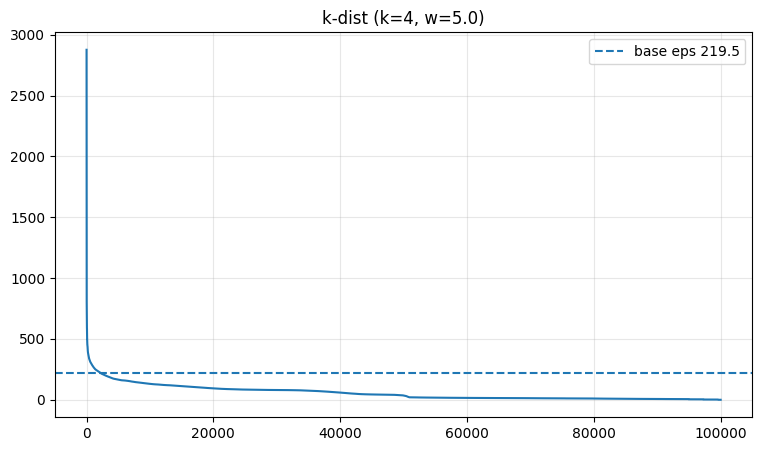

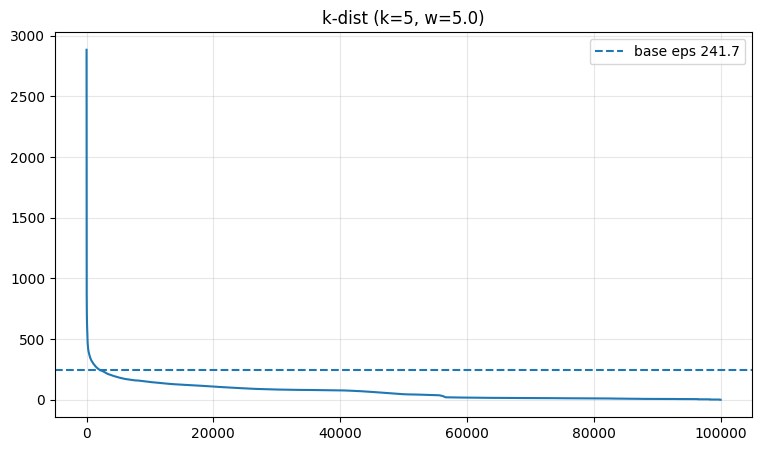

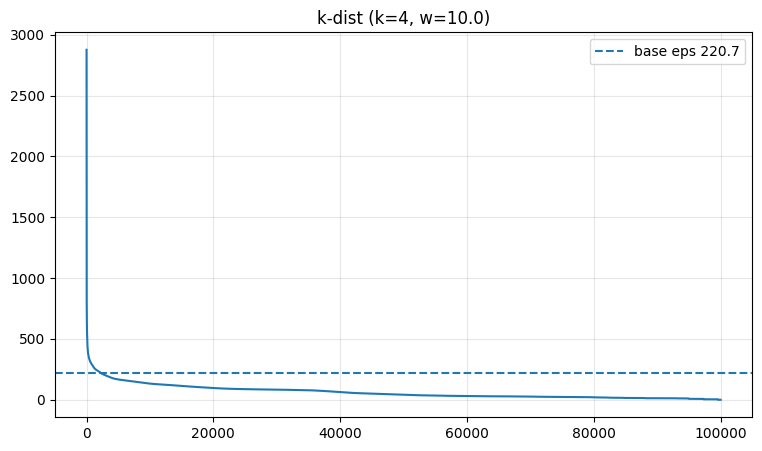

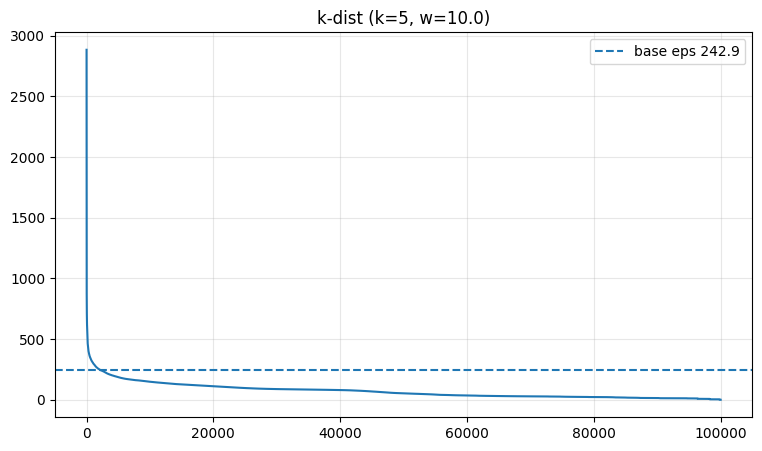

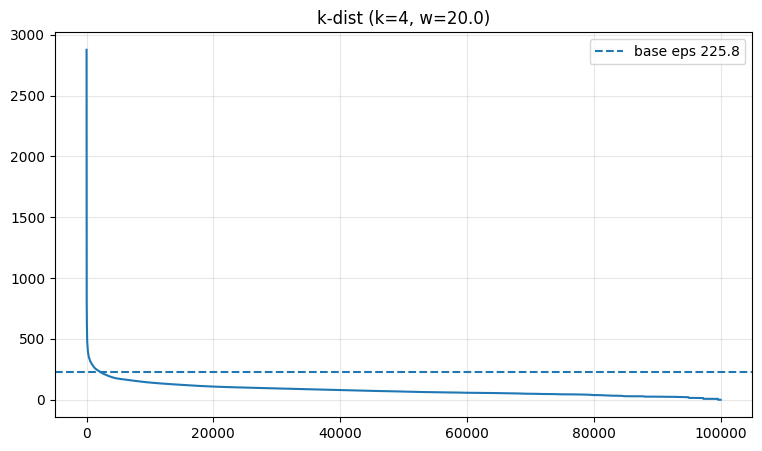

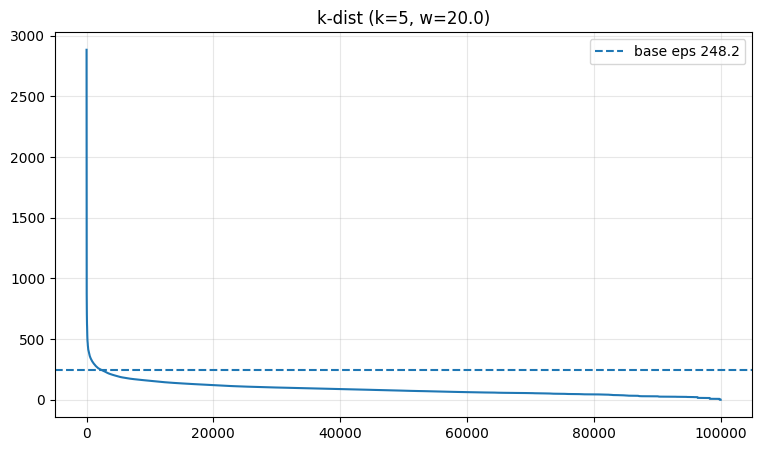

Testing: eps=65.8638, min_samples=4, temporal_weight=5.0
Testing: eps=87.8184, min_samples=4, temporal_weight=5.0
Testing: eps=109.773, min_samples=4, temporal_weight=5.0
Testing: eps=131.728, min_samples=4, temporal_weight=5.0
Testing: eps=72.5242, min_samples=5, temporal_weight=5.0
Testing: eps=96.699, min_samples=5, temporal_weight=5.0
Testing: eps=120.874, min_samples=5, temporal_weight=5.0
Testing: eps=145.048, min_samples=5, temporal_weight=5.0
Testing: eps=66.2056, min_samples=4, temporal_weight=10.0
Testing: eps=88.2742, min_samples=4, temporal_weight=10.0
Testing: eps=110.343, min_samples=4, temporal_weight=10.0
Testing: eps=132.411, min_samples=4, temporal_weight=10.0
Testing: eps=72.8603, min_samples=5, temporal_weight=10.0
Testing: eps=97.1471, min_samples=5, temporal_weight=10.0
Testing: eps=121.434, min_samples=5, temporal_weight=10.0
Testing: eps=145.721, min_samples=5, temporal_weight=10.0
Testing: eps=67.7323, min_samples=4, temporal_weight=20.0
Testing: eps=90.3098, m

,eps,min_samples,temporal_weight,n_clusters,noise_ratio,silhouette,runtime_s,avg_cluster_radius_m,median_cluster_radius_m
0,65.863827,4,5.0,6117,0.28328,0.561546,0.607985,13.784764,0.150671
1,72.524239,5,5.0,4461,0.32478,0.511200,0.956572,17.993172,0.567534
2,66.205618,4,10.0,6096,0.29067,0.505574,0.727759,13.017331,0.148689
3,72.860344,5,10.0,4455,0.33492,0.475752,0.482756,16.967701,0.356857
4,67.732340,4,20.0,5656,0.35159,0.447330,0.442268,8.758430,0.099127
5,74.454245,5,20.0,4306,0.37827,0.430588,0.868049,12.751639,0.180802
6,90.309786,4,20.0,4337,0.19629,0.142331,1.406729,32.198819,20.214375
7,88.274157,4,10.0,4109,0.14452,0.036448,0.995333,43.253381,30.153658
8,87.818436,4,5.0,4044,0.13349,0.024238,2.831801,45.516122,31.465016
9,99.272327,5,20.0,2920,0.18955,-0.023056,0.878337,46.084884,31.219121



Best config (silhouette-first): eps=65.86382714445652 | min_samples=4 | temporal_weight=5.0
Labeled: 100,000 rows | clusters (excl. noise): 6117 | noise: 28.33%


In [ ]:
# --- DBSCAN spatio-temporal: Pipeline + parameter sweep with k-dist pre-stage ---

# 0) Choose dataset (sample vs full) and sanitize
USE_SAMPLE = False
DF_IN = df_spatial_sample if USE_SAMPLE else df_spatial

REQUIRED = ["Latitude", "Longitude", "HOUR", "WEEKDAY"]
missing_cols = [c for c in REQUIRED if c not in DF_IN.columns]
if missing_cols:
    raise ValueError(f"Input DataFrame is missing required columns: {missing_cols}")

DF_RUN = DF_IN.dropna(subset=REQUIRED).copy()
if len(DF_RUN) < len(DF_IN):
    print(f"Filtered {len(DF_IN)-len(DF_RUN):,} rows with NaNs in {REQUIRED} (kept {len(DF_RUN):,}).")

# 1) Preprocessing & pipeline
def weight_func(X, w=1.0):
    return X * w

temporal_block = Pipeline([
    ("cyc", CyclicalTransformer()),  # -> *_SIN, *_COS
    ("sc", StandardScaler()),
    ("weight", FunctionTransformer(weight_func, kw_args={"w": 1.0}, feature_names_out="one-to-one"))
])

pre = ColumnTransformer(
    transformers=[
        ("spatial", SpatialProjectionTransformer(crs="EPSG:32618", drop_latlon=True),
         ["Latitude", "Longitude"]),
        ("temporal", temporal_block, ["HOUR", "WEEKDAY"])
    ],
    remainder="drop",
    verbose_feature_names_out=False
)

pipe = Pipeline([
    ("pre", pre),
    ("cluster", DBSCAN(metric="euclidean", n_jobs=-1))
])

# -------------------------------------------------------------------
# 2) k-distance helpers
# -------------------------------------------------------------------

# --- elbow where aggregated slope ~= -1 (bucketed) ----------------------------
def eps_from_slope_minus_one_bucketed(kdist, slope_target=-1.0, bin_frac=0.003, smooth_bins=5, skip_head_frac=0.02):
    """
    Bucket the descending k-dist curve, compute median per bucket, smooth across buckets,
    then pick the first index where the aggregated slope crosses up to ~ -1.
    Returns (eps, elbow_idx, slope_at_elbow).
    """
    y = np.asarray(kdist, dtype=float)
    n = len(y)
    # bucket size = ~bin_frac of the curve (e.g. 0.3% -> ~300 pts if n=100k)
    bin_size = max(50, int(n * bin_frac))
    n_bins = max(2, int(np.ceil(n / bin_size)))

    bx, by = [], []
    for b in range(n_bins):
        s = b * bin_size
        e = min(n, s + bin_size)
        if e - s < 3:
            continue
        bx.append((s + e - 1) / 2.0)            # bin center (in original index units)
        by.append(float(np.median(y[s:e])))     # robust aggregate

    bx = np.asarray(bx); by = np.asarray(by)
    if len(bx) < 3:
        # fallback: closest single-point slope method
        j = int(np.floor(n * 0.05))
        return float(y[j]), j, np.nan

    # optional smoothing across buckets
    if smooth_bins > 1:
        ker = np.ones(int(smooth_bins), dtype=float) / int(smooth_bins)
        by_s = np.convolve(by, ker, mode='same')
    else:
        by_s = by

    slope = np.gradient(by_s, bx)  # dy/dx on aggregated curve (negative on descending)

    # skip the very steep head (e.g., first 2% of buckets)
    skip = int(max(0, round(len(bx) * skip_head_frac)))
    cand = np.where(slope[skip:] >= slope_target)[0]
    if cand.size:
        j_bucket = cand[0] + skip
    else:
        j_bucket = int(np.argmin(np.abs(slope - slope_target)))

    # map back to original curve using nearest integer index
    elbow_idx = int(round(bx[j_bucket]))
    elbow_idx = int(np.clip(elbow_idx, 0, n - 1))
    return float(y[elbow_idx]), elbow_idx, float(slope[j_bucket])


def param_grid_from_kdist_pairs(
    df, preprocessor, *,
    temporal_weights=(5.0, 10.0, 20.0),
    ks=(3, 4, 5, 6, 8),                      
    spread=(0.3, 0.5, 0.7, 0.9, 1.0),
    plot=False,
    eps_floor=1e-6,
    eps_cap_m=500.0,
    eps_strategy="slope-1-bucketed"
):
    grid = []
    for tw in temporal_weights:
        pre_w = clone(preprocessor).set_params(temporal__weight__kw_args={"w": tw})
        X_feats = np.asarray(pre_w.fit_transform(df))

        for k in ks:
            # build k-dist
            nbrs = NearestNeighbors(n_neighbors=k+1).fit(X_feats)
            dists, _ = nbrs.kneighbors(X_feats)
            kdist = np.sort(dists[:, k])[::-1]

            # choose base eps
            if eps_strategy == "slope-1-bucketed":
                eps_k, elbow_idx, elbow_slope = eps_from_slope_minus_one_bucketed(
                    kdist, slope_target=-1.0, bin_frac=0.003, smooth_bins=5, skip_head_frac=0.02
                )


            # build candidate list with downward multipliers and a hard cap
            eps_list = sorted({
                max(eps_floor, min(eps_k * m, eps_cap_m)) for m in spread
            })

            grid.append({
                "cluster__eps": eps_list,                         # LIST
                "cluster__min_samples": [k],                      # LIST
                "pre__temporal__weight__kw_args": [{"w": tw}],    # LIST
            })

            if plot:
                plt.figure(figsize=(9,5))
                plt.plot(range(len(kdist)), kdist)
                plt.axhline(eps_k, linestyle='--', label=f'base eps {eps_k:.1f}')
                plt.title(f'k-dist (k={k}, w={tw})'); plt.grid(True, alpha=0.3); plt.legend(); plt.show()

    return grid


# -------------------------------------------------------------------
# 3) Build the focused grid via k-dist
# -------------------------------------------------------------------
param_grid = param_grid_from_kdist_pairs(
    DF_RUN, pre,
    temporal_weights=(5.0, 10.0, 20.0),
    ks=(4, 5),
    spread=(0.3, 0.4, 0.5, 0.6),
    eps_cap_m=200.0,
    eps_strategy="slope-1-bucketed",
    plot=True
)


# -------------------------------------------------------------------
# 4) Sweep helpers
# -------------------------------------------------------------------
def _spatial_indices_from_pre(pre_fitted):
    names = list(pre_fitted.get_feature_names_out())
    ix_x = names.index("X_METERS") if "X_METERS" in names else names.index("spatial__X_METERS")
    ix_y = names.index("Y_METERS") if "Y_METERS" in names else names.index("spatial__Y_METERS")
    return ix_x, ix_y

def _spatial_compactness(X_all, labels, ix_x, ix_y):
    out = {"avg_cluster_radius_m": np.nan, "median_cluster_radius_m": np.nan}
    uniq = np.unique(labels)
    uniq = uniq[uniq != -1]
    if uniq.size == 0:
        return out
    XY = X_all[:, [ix_x, ix_y]]
    radii = []
    for c in uniq:
        pts = XY[labels == c]
        if len(pts) < 2:
            continue
        center = pts.mean(axis=0)
        d = np.linalg.norm(pts - center, axis=1)
        radii.append(np.median(d))
    if not radii:
        return out
    out["avg_cluster_radius_m"] = float(np.mean(radii))
    out["median_cluster_radius_m"] = float(np.median(radii))
    return out

# -------------------------------------------------------------------
# 5) Manual grid search (same as before; now uses the focused grid)
# -------------------------------------------------------------------
results = []
best_params = None
best_score = -np.inf

for params in ParameterGrid(param_grid):
    print(f"Testing: eps={float(params['cluster__eps']):.6g}, "
          f"min_samples={params['cluster__min_samples']}, "
          f"temporal_weight={params['pre__temporal__weight__kw_args']['w']}")
    pipe.set_params(**params)
    t0 = time.perf_counter()
    labels = pipe.fit_predict(DF_RUN)
    dt = time.perf_counter() - t0

    X_all = pipe.named_steps["pre"].transform(DF_RUN)
    X_all = np.asarray(X_all)

    n_total = len(labels)
    n_noise = int(np.sum(labels == -1))
    noise_ratio = n_noise / max(n_total, 1)

    valid_mask = labels != -1
    unique_valid = np.unique(labels[valid_mask])
    sil = silhouette_score(X_all[valid_mask], labels[valid_mask], metric="euclidean") \
          if valid_mask.sum() >= 2 and unique_valid.size >= 2 else np.nan

    ix_x, ix_y = _spatial_indices_from_pre(pipe.named_steps["pre"])
    compact = _spatial_compactness(X_all, labels, ix_x, ix_y)

    row = {
        "eps": float(params["cluster__eps"]),
        "min_samples": int(params["cluster__min_samples"]),
        "temporal_weight": float(params["pre__temporal__weight__kw_args"]["w"]),
        "n_clusters": int(np.unique(labels[labels != -1]).size),
        "noise_ratio": float(noise_ratio),
        "silhouette": float(sil) if np.isfinite(sil) else np.nan,
        "runtime_s": float(dt),
        **compact,
    }
    results.append(row)

    score_key = (np.nan_to_num(sil, nan=-1), -noise_ratio, row["n_clusters"])
    best_key_now = (np.nan_to_num(best_score, nan=-1), -1.0, -1)
    if score_key > best_key_now:
        best_score = sil
        best_params = {
            "cluster__eps": row["eps"],
            "cluster__min_samples": row["min_samples"],
            "pre__temporal__weight__kw_args": {"w": row["temporal_weight"]}
        }

# 6) Results table & best refit
res_df = pd.DataFrame(results).sort_values(
    by=["silhouette", "noise_ratio", "n_clusters"],
    ascending=[False, True, False],
    na_position="last"
).reset_index(drop=True)

display(res_df.head(15))

if best_params is None:
    raise RuntimeError("No valid configuration found (DBSCAN produced <2 clusters across grid).")

print(
    f"\nBest config (silhouette-first): eps={best_params['cluster__eps']} | "
    f"min_samples={best_params['cluster__min_samples']} | "
    f"temporal_weight={best_params['pre__temporal__weight__kw_args']['w']}"
)

best_pipe = clone(pipe).set_params(**best_params).fit(DF_RUN)
best_labels = best_pipe.named_steps["cluster"].labels_

X_all_best = best_pipe.named_steps["pre"].transform(DF_RUN)
X_all_best = np.asarray(X_all_best)
ix_x_best, ix_y_best = _spatial_indices_from_pre(best_pipe.named_steps["pre"])

coords_labels_df = pd.DataFrame({
    "X_METERS": X_all_best[:, ix_x_best],
    "Y_METERS": X_all_best[:, ix_y_best],
    "cluster": best_labels
})

df_labeled = DF_RUN.copy()
df_labeled["X_METERS"] = coords_labels_df["X_METERS"].values
df_labeled["Y_METERS"] = coords_labels_df["Y_METERS"].values
df_labeled["cluster"] = coords_labels_df["cluster"].values

print(f"Labeled: {len(best_labels):,} rows | clusters (excl. noise): "
      f"{np.unique(best_labels[best_labels!=-1]).size} | noise: {(best_labels==-1).mean():.2%}")


### Best parameters model

In [41]:
# --- Use the best DBSCAN pipeline: refit (optional), label data, and profile clusters ---

# ---------- 0) Resolve "best" safely ----------
if 'best_params' not in locals() or best_params is None:
    # fallback: take the top row of res_df if available
    if 'res_df' in locals() and not res_df.empty:
        top = res_df.iloc[0]
        best_params = {
            "cluster__eps": float(top["eps"]),
            "cluster__min_samples": int(top["min_samples"]),
            "pre__temporal__weight__kw_args": {"w": float(top["temporal_weight"])},
        }
    else:
        raise RuntimeError("Best params not found. Run the sweep cell first.")

# ---------- 1) Choose data to fit on ----------
USE_FULL_DATA = True  # True -> fit on df_spatial; False -> fit on DF_RUN (sample/cleaned)

if USE_FULL_DATA:
    df_used = df_spatial
else:
    # Use the same cleaned DF_RUN used during the sweep
    df_used = DF_RUN

# ---------- 2) Fit a fresh pipeline with the best params ----------
best_pipe = clone(pipe).set_params(**best_params).fit(df_used)
labels_all = best_pipe.named_steps["cluster"].labels_

# ---------- 3) Attach labels ----------
df_labeled = df_used.copy()
df_labeled["cluster"] = labels_all

# ---------- 4) Extract X/Y in meters from the fitted preprocessor ----------
def _xy_indices(pre_fitted):
    names = list(pre_fitted.get_feature_names_out())
    ix_x = names.index("X_METERS") if "X_METERS" in names else names.index("spatial__X_METERS")
    ix_y = names.index("Y_METERS") if "Y_METERS" in names else names.index("spatial__Y_METERS")
    return ix_x, ix_y

X_all = np.asarray(best_pipe.named_steps["pre"].transform(df_used))
ix_x, ix_y = _xy_indices(best_pipe.named_steps["pre"])
df_labeled["X_METERS"] = X_all[:, ix_x]
df_labeled["Y_METERS"] = X_all[:, ix_y]

# ---------- 5) Quick cluster profiling ----------
def _cluster_profiles(df):
    g = df[df["cluster"] != -1].groupby("cluster", sort=True)

    # centroids (meters)
    centroids = g[["X_METERS","Y_METERS"]].mean().rename(
        columns={"X_METERS":"centroid_x_m","Y_METERS":"centroid_y_m"}
    )

    # median radius (meters) around centroid
    def median_radius(gr):
        c = gr[["X_METERS","Y_METERS"]].mean().values
        d = np.linalg.norm(gr[["X_METERS","Y_METERS"]].values - c, axis=1)
        return np.median(d) if len(d) else np.nan

    radius = g.apply(median_radius).rename("median_radius_m")

    # optional temporal modes if columns exist
    temporal_cols = [c for c in ["HOUR","WEEKDAY"] if c in df.columns]
    if temporal_cols:
        temporal_modes = g[temporal_cols].agg(lambda s: s.mode().iloc[0] if not s.mode().empty else np.nan)
        prof = pd.concat([centroids, radius, temporal_modes], axis=1)
    else:
        prof = pd.concat([centroids, radius], axis=1)

    prof["n_points"] = g.size()
    return prof.reset_index()

profiles = _cluster_profiles(df_labeled)

# ---------- 6) Noise summary ----------
n_total = len(df_labeled)
n_noise = int((df_labeled["cluster"] == -1).sum())
noise_ratio = n_noise / max(n_total, 1)

print(f"Total points: {n_total} | Clusters (excl. noise): {profiles.shape[0]} | Noise ratio: {noise_ratio:.3f}")
display(profiles.head(15))

# ---------- 7) Convert centroids back to lat/lon (uses pipeline CRS if available) ----------
# Try to read the CRS from the fitted spatial transformer; fallback to EPSG:32618
try:
    crs_proj = best_pipe.named_steps["pre"].named_transformers_["spatial"].crs
except Exception:
    crs_proj = "EPSG:32618"

to_wgs84 = Transformer.from_crs(crs_proj, "EPSG:4326", always_xy=True)
lon, lat = to_wgs84.transform(profiles["centroid_x_m"].values, profiles["centroid_y_m"].values)
profiles["centroid_lat"] = lat
profiles["centroid_lon"] = lon

display(profiles[["cluster","n_points","median_radius_m","centroid_lat","centroid_lon"]].head(15))

# ---------- 8) Persist fitted pipeline ----------
# joblib.dump(best_pipe, "dbscan_spatiotemporal_pipeline.joblib")
# print("Saved fitted pipeline -> dbscan_spatiotemporal_pipeline.joblib")


Total points: 560819 | Clusters (excl. noise): 18303 | Noise ratio: 0.046


,cluster,centroid_x_m,centroid_y_m,median_radius_m,HOUR,WEEKDAY,n_points
0,0,563567.634848,4.484853e+06,11.600517,8,THURSDAY,95
1,1,563504.937845,4.485018e+06,5.981455,17,FRIDAY,9
2,2,563667.363826,4.485166e+06,0.000000,1,SUNDAY,4
3,3,563687.899933,4.484692e+06,21.856899,3,THURSDAY,8
4,4,563789.829552,4.484552e+06,17.522306,4,SUNDAY,5
5,5,563840.571127,4.484399e+06,0.000000,15,FRIDAY,4
6,6,563923.138051,4.485183e+06,17.209975,8,SUNDAY,4
7,7,564106.980981,4.484660e+06,72.944805,10,SATURDAY,21
8,8,563913.145909,4.484423e+06,0.000000,20,FRIDAY,7
9,9,564002.263051,4.484416e+06,0.000000,2,THURSDAY,4


,cluster,n_points,median_radius_m,centroid_lat,centroid_lon
0,0,95,11.600517,40.511958,-74.249667
1,1,9,5.981455,40.513458,-74.250390
2,2,4,0.000000,40.514779,-74.248458
3,3,8,21.856899,40.510501,-74.248263
4,4,5,17.522306,40.509237,-74.247074
5,5,4,0.000000,40.507851,-74.246491
6,6,4,17.209975,40.514913,-74.245437
7,7,21,72.944805,40.510185,-74.243320
8,8,7,0.000000,40.508066,-74.245632
9,9,4,0.000000,40.507991,-74.244581


### Best model visualization

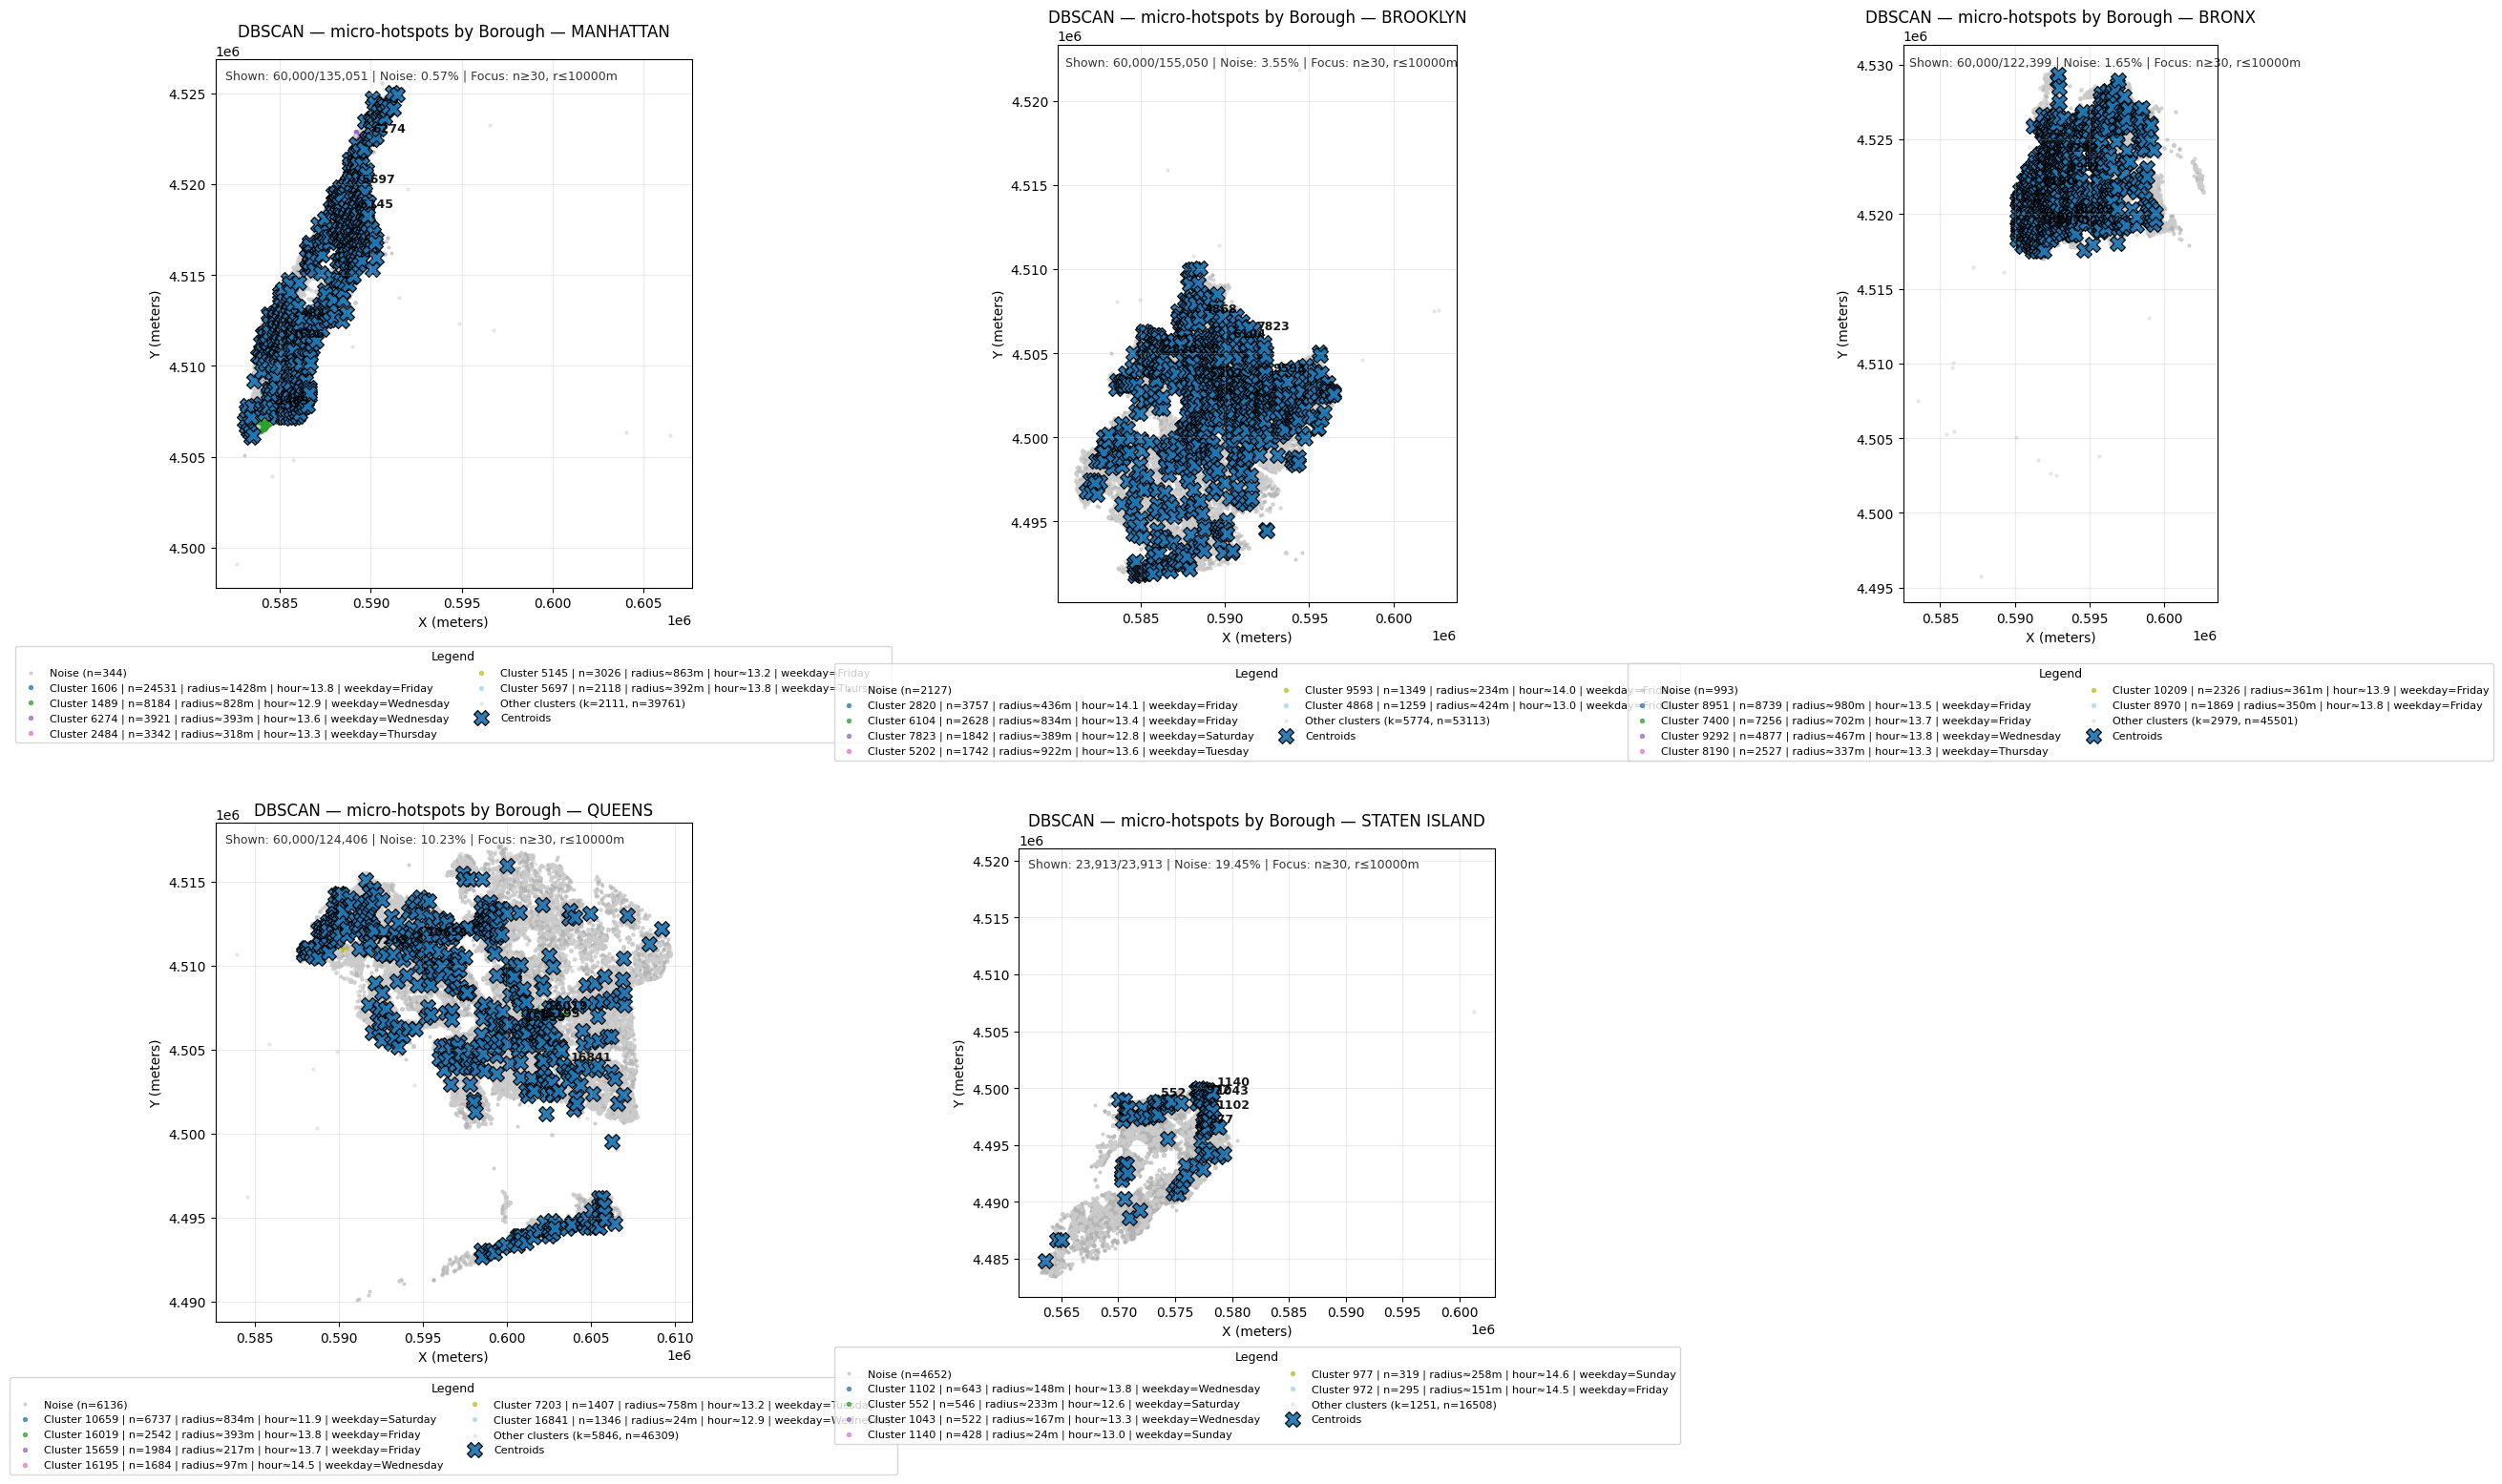

In [42]:
# --- Static visualization for micro-hotspots ---

_WEEKDAY_ORDER = ["MONDAY","TUESDAY","WEDNESDAY","THURSDAY","FRIDAY","SATURDAY","SUNDAY"]

def _median_radius_m_from_df(df):
    if df.empty:
        return np.nan
    c = df[["X_METERS","Y_METERS"]].mean().values
    d = np.linalg.norm(df[["X_METERS","Y_METERS"]].values - c, axis=1)
    return float(np.median(d)) if len(d) else np.nan

def _weekday_mode(series):
    wd = series.astype(str).str.upper()
    wd = wd.where(wd.isin(_WEEKDAY_ORDER), np.nan)
    mode = wd.mode()
    return mode.iloc[0].title() if not mode.empty else np.nan

def _legend_label(c, stats_row):
    parts = [f"Cluster {int(c)}", f"n={int(stats_row['n'])}"]
    if pd.notna(stats_row.get("median_radius_m", np.nan)):
        parts.append(f"radius≈{stats_row['median_radius_m']:.0f}m")
    if pd.notna(stats_row.get("hour_mean", np.nan)):
        parts.append(f"hour≈{stats_row['hour_mean']:.1f}")
    if isinstance(stats_row.get("weekday_mode", np.nan), str):
        parts.append(f"weekday={stats_row['weekday_mode']}")
    return " | ".join(parts)

def plot_clusters(
    df_labeled: pd.DataFrame,
    title: str = "DBSCAN (spatio-temporal micro-hotspots) — meter space",
    sample_max: int = 120_000,
    top_k_legend: int = 10,
    focus_only: bool = True,
    min_points: int = 30,          # keep clusters with at least N points (actionable)
    max_radius_m: float = 800.0,   # keep clusters with median radius <= max_radius_m (micro-hotspots)
    show_centroids: bool = True,
    annotate_topk: bool = True
):
    # Safety
    needed = {"X_METERS","Y_METERS","cluster"}
    missing = needed - set(df_labeled.columns)
    if missing:
        raise ValueError(f"df_labeled is missing columns: {missing}")

    # Compute per-cluster stats from FULL data (not the sample)
    grp = df_labeled[df_labeled["cluster"] != -1].groupby("cluster", sort=True)
    stats = pd.DataFrame({
        "n": grp.size(),
        "centroid_x_m": grp["X_METERS"].mean(),
        "centroid_y_m": grp["Y_METERS"].mean(),
        "median_radius_m": grp.apply(_median_radius_m_from_df)
    })
    # temporal summaries if available
    if "HOUR" in df_labeled.columns:
        stats["hour_mean"] = grp["HOUR"].mean()
    if "WEEKDAY" in df_labeled.columns:
        stats["weekday_mode"] = grp["WEEKDAY"].apply(_weekday_mode)

    # Focus filter for micro-hotspots
    if focus_only:
        mask = (stats["n"] >= min_points) & (stats["median_radius_m"] <= max_radius_m)
        stats = stats[mask]

    # If nothing passes the focus filter, fall back to top by size
    if stats.empty:
        stats = pd.DataFrame({
            "n": grp.size(),
            "centroid_x_m": grp["X_METERS"].mean(),
            "centroid_y_m": grp["Y_METERS"].mean(),
            "median_radius_m": grp.apply(_median_radius_m_from_df)
        }).sort_values("n", ascending=False).head(top_k_legend)

        if "HOUR" in df_labeled.columns:
            stats["hour_mean"] = grp["HOUR"].mean()
        if "WEEKDAY" in df_labeled.columns:
            stats["weekday_mode"] = grp["WEEKDAY"].apply(_weekday_mode)

    # Determine which clusters to highlight in legend
    highlight = stats.sort_values(["n", "median_radius_m"], ascending=[False, True]).head(top_k_legend)
    top_clusters = list(highlight.index)

    # Build plotting sample for speed
    plot_df = df_labeled if len(df_labeled) <= sample_max else df_labeled.sample(sample_max, random_state=42)

    # Counts / noise
    counts = plot_df["cluster"].value_counts(dropna=False)
    n_total = int(len(plot_df))
    n_noise = int(counts.get(-1, 0))
    noise_ratio = n_noise / max(n_total, 1)

    # Colors
    cmap = plt.cm.get_cmap("tab20", max(2, len(top_clusters)))
    color_top = {c: cmap(i) for i, c in enumerate(top_clusters)}
    color_noise = (0.7, 0.7, 0.7, 0.35)
    color_other = (0.80, 0.80, 0.80, 0.35)

    # Plot
    fig, ax = plt.subplots(figsize=(9, 9))

    # Noise
    if n_noise > 0:
        sdf = plot_df[plot_df["cluster"] == -1]
        ax.scatter(sdf["X_METERS"], sdf["Y_METERS"], s=4, alpha=0.5, label=f"Noise (n={len(sdf)})", c=[color_noise])

    # Top clusters (descriptive legend)
    for c in top_clusters:
        sdf = plot_df[plot_df["cluster"] == c]
        label_txt = _legend_label(c, stats.loc[c])
        ax.scatter(sdf["X_METERS"], sdf["Y_METERS"], s=8, alpha=0.7, c=[color_top[c]], label=label_txt)

    # Other clusters (shown subdued)
    others = [c for c in plot_df["cluster"].unique() if c not in top_clusters and c != -1]
    if len(others) > 0:
        sdf = plot_df[plot_df["cluster"].isin(others)]
        ax.scatter(sdf["X_METERS"], sdf["Y_METERS"], s=5, alpha=0.35,
                   label=f"Other clusters (k={len(others)}, n={len(sdf)})", c=[color_other])

    # Centroids
    if show_centroids and not stats.empty:
        ax.scatter(
            stats["centroid_x_m"], stats["centroid_y_m"],
            s=130, marker="X", linewidth=0.9, edgecolor="black", alpha=0.95, label="Centroids"
        )
        if annotate_topk:
            ann = stats.loc[top_clusters]
            for cid, r in ann.iterrows():
                ax.annotate(f"{int(cid)}", (float(r["centroid_x_m"]), float(r["centroid_y_m"])),
                            xytext=(5,5), textcoords="offset points",
                            fontsize=9, weight="bold", alpha=0.9)

    # Titles & layout
    ax.set_title(title, fontsize=13)
    ax.set_xlabel("X (meters)")
    ax.set_ylabel("Y (meters)")
    ax.set_aspect("equal")

    ax.text(0.02, 0.98,
            f"Shown: {len(plot_df):,}/{len(df_labeled):,} | Noise: {noise_ratio:.2%} | "
            f"Focus: n≥{min_points}, radius≤{int(max_radius_m)}m",
            transform=ax.transAxes, va="top", ha="left", fontsize=9, alpha=0.8)

    # Legend below plot
    leg = ax.legend(loc="upper center", bbox_to_anchor=(0.5, -0.08),
                    ncol=1 if len(top_clusters) <= 4 else 2, frameon=True, fontsize=9)
    if leg:
        leg.set_title("Legend", prop={"size": 10})

    ax.grid(True, alpha=0.25)
    plt.tight_layout()
    plt.show()

def _auto_detect_zone_col(df: pd.DataFrame, fallback: str | None = None) -> str:
    candidates = ["BOROUGH", "Borough", "BORO_NM", "NEIGHBORHOOD", "NTA_NAME", "Precinct", "PRECINCT"]
    if fallback and fallback in df.columns:
        return fallback
    for c in candidates:
        if c in df.columns:
            return c
    raise ValueError(
        f"Could not detect a zone column. "
        f"Pass zone_col explicitly (e.g., zone_col='BOROUGH'). "
        f"Available columns: {list(df.columns)[:20]}..."
    )

def plot_clusters_by_zone(
    df_labeled: pd.DataFrame,
    zone_col: str | None = None,
    zones: list[str] | None = None,     # subset like ["MANHATTAN","BROOKLYN"] if you want
    title: str = "DBSCAN — micro-hotspots by zone",
    sample_max_per_zone: int = 60_000,
    top_k_legend: int = 6,
    focus_only: bool = True,
    min_points: int = 30,
    max_radius_m: float = 800.0,
    show_centroids: bool = True,
    annotate_topk: bool = True,
    ncols: int = 3,                      # columns in the facet grid
):
    # --- Safety
    required = {"X_METERS", "Y_METERS", "cluster"}
    miss = required - set(df_labeled.columns)
    if miss:
        raise ValueError(f"df_labeled is missing columns: {miss}")
    
    # Detect zone column if not provided
    zone_col = _auto_detect_zone_col(df_labeled, zone_col)

    # Get zone list
    all_zones = [z for z in df_labeled[zone_col].dropna().unique().tolist()]
    # sort for consistency (strings first, then numbers)
    try:
        all_zones = sorted(all_zones, key=lambda x: (str(type(x)), x))
    except Exception:
        all_zones = sorted(all_zones, key=str)
    zone_list = zones if zones is not None else all_zones
    if len(zone_list) == 0:
        raise ValueError(f"No zones found in column '{zone_col}'.")

    # Prepare facet grid
    n = len(zone_list)
    ncols = max(1, ncols)
    nrows = math.ceil(n / ncols)
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(8.5*ncols, 8*nrows))
    axes = np.atleast_1d(axes).reshape(nrows, ncols)

    # --- Plot each zone
    for idx, zone in enumerate(zone_list):
        r, c = divmod(idx, ncols)
        ax = axes[r, c]
        sub = df_labeled[df_labeled[zone_col] == zone].copy()

        # If empty or only noise, just annotate
        if sub.empty or (sub["cluster"].nunique() == 1 and sub["cluster"].unique()[0] == -1):
            ax.set_title(f"{zone} — no clusters", fontsize=12)
            ax.set_xlabel("X (meters)"); ax.set_ylabel("Y (meters)"); ax.set_aspect("equal")
            ax.grid(True, alpha=0.25)
            continue

        # Compute per-cluster stats within this zone
        grp = sub[sub["cluster"] != -1].groupby("cluster", sort=True)
        stats = pd.DataFrame({
            "n": grp.size(),
            "centroid_x_m": grp["X_METERS"].mean(),
            "centroid_y_m": grp["Y_METERS"].mean(),
            "median_radius_m": grp.apply(_median_radius_m_from_df)
        })
        if "HOUR" in sub.columns:
            stats["hour_mean"] = grp["HOUR"].mean()
        if "WEEKDAY" in sub.columns:
            stats["weekday_mode"] = grp["WEEKDAY"].apply(_weekday_mode)

        # Focus filter (actionable micro-hotspots)
        if focus_only and not stats.empty:
            mask = (stats["n"] >= min_points) & (stats["median_radius_m"] <= max_radius_m)
            stats = stats[mask]

        # If still empty, fall back to top by size
        if stats.empty:
            stats = pd.DataFrame({
                "n": grp.size(),
                "centroid_x_m": grp["X_METERS"].mean(),
                "centroid_y_m": grp["Y_METERS"].mean(),
                "median_radius_m": grp.apply(_median_radius_m_from_df)
            }).sort_values("n", ascending=False).head(top_k_legend)
            if "HOUR" in sub.columns:
                stats["hour_mean"] = grp["HOUR"].mean()
            if "WEEKDAY" in sub.columns:
                stats["weekday_mode"] = grp["WEEKDAY"].apply(_weekday_mode)

        # Sort and pick Top-K for legend
        highlight = stats.sort_values(["n", "median_radius_m"], ascending=[False, True]).head(top_k_legend)
        top_clusters = list(highlight.index)

        # Sample points for speed
        plot_df = sub if len(sub) <= sample_max_per_zone else sub.sample(sample_max_per_zone, random_state=42)

        # Counts / noise
        counts = plot_df["cluster"].value_counts(dropna=False)
        n_total = int(len(plot_df))
        n_noise = int(counts.get(-1, 0))
        noise_ratio = n_noise / max(n_total, 1)

        # Colors for this zone
        cmap = plt.cm.get_cmap("tab20", max(2, len(top_clusters)))
        color_top = {cl: cmap(i) for i, cl in enumerate(top_clusters)}
        color_noise = (0.7, 0.7, 0.7, 0.35)
        color_other = (0.80, 0.80, 0.80, 0.35)

        # Plot noise
        if n_noise > 0:
            sdf = plot_df[plot_df["cluster"] == -1]
            ax.scatter(sdf["X_METERS"], sdf["Y_METERS"], s=4, alpha=0.5,
                       label=f"Noise (n={len(sdf)})", c=[color_noise])

        # Plot top clusters with descriptive legend
        for cl in top_clusters:
            sdf = plot_df[plot_df["cluster"] == cl]
            label_txt = _legend_label(cl, stats.loc[cl])
            ax.scatter(sdf["X_METERS"], sdf["Y_METERS"], s=8, alpha=0.7,
                       c=[color_top[cl]], label=label_txt)

        # Other clusters (subdued)
        others = [cl for cl in plot_df["cluster"].unique() if cl not in top_clusters and cl != -1]
        if len(others) > 0:
            sdf = plot_df[plot_df["cluster"].isin(others)]
            ax.scatter(sdf["X_METERS"], sdf["Y_METERS"], s=5, alpha=0.35,
                       label=f"Other clusters (k={len(others)}, n={len(sdf)})", c=[color_other])

        # Centroids overlay
        if show_centroids and not stats.empty:
            ax.scatter(stats["centroid_x_m"], stats["centroid_y_m"],
                       s=130, marker="X", linewidth=0.9,
                       edgecolor="black", alpha=0.95, label="Centroids")
            if annotate_topk:
                ann = stats.loc[top_clusters]
                for cid, rrow in ann.iterrows():
                    ax.annotate(f"{int(cid)}", (float(rrow["centroid_x_m"]), float(rrow["centroid_y_m"])),
                                xytext=(5,5), textcoords="offset points",
                                fontsize=9, weight="bold", alpha=0.9)

        # Titles, labels
        ax.set_title(f"{title} — {zone}", fontsize=12)
        ax.set_xlabel("X (meters)"); ax.set_ylabel("Y (meters)")
        ax.set_aspect("equal")
        ax.text(0.02, 0.98,
                f"Shown: {len(plot_df):,}/{len(sub):,} | Noise: {noise_ratio:.2%} | "
                f"Focus: n≥{min_points}, r≤{int(max_radius_m)}m",
                transform=ax.transAxes, va="top", ha="left", fontsize=9, alpha=0.8)
        ax.grid(True, alpha=0.25)
        ax.ticklabel_format(axis='x', style='sci', scilimits=(6, 6))
        # Legend under each axis
        leg = ax.legend(loc="upper center", bbox_to_anchor=(0.5, -0.10),
                        ncol=1 if len(top_clusters) <= 4 else 2, frameon=True, fontsize=8)
        if leg:
            leg.set_title("Legend", prop={"size": 9})

    # Remove empty axes if grid not full
    for j in range(n, nrows*ncols):
        r, c = divmod(j, ncols)
        axes[r, c].axis("off")

    plt.tight_layout()
    plt.show()


plot_clusters_by_zone(
    df_labeled,
    title="DBSCAN — micro-hotspots by Borough",
    top_k_legend=6,
    focus_only=True,
    zones=["MANHATTAN", "BROOKLYN", "BRONX", "QUEENS", "STATEN ISLAND"],
    min_points=30,
    max_radius_m=10000.0,
    ncols=3
)

## 4. Spatio-Temporal hotspots



In [57]:
# --- Temporal Pattern Analysis of Spatio-Temporal Clusters --------------------

def analyze_cluster_temporal_patterns(df_labeled, min_cluster_size=10):
    """
    Analyze temporal patterns within existing spatio-temporal clusters.
    Returns comprehensive statistics for each cluster across different time dimensions.
    """
    # Filter out noise first
    df_no_noise = df_labeled[df_labeled['cluster'] != -1].copy()
    
    if df_no_noise.empty:
        print("No valid clusters found (all are noise)")
        return pd.DataFrame()
    
    # Get cluster sizes and filter by minimum size
    cluster_sizes = df_no_noise['cluster'].value_counts()
    valid_clusters = cluster_sizes[cluster_sizes >= min_cluster_size].index
    
    if len(valid_clusters) == 0:
        print(f"No clusters found with at least {min_cluster_size} incidents")
        return pd.DataFrame()
    
    # Filter data to only include valid clusters
    df_clean = df_no_noise[df_no_noise['cluster'].isin(valid_clusters)].copy()
    
    print(f"Processing {len(valid_clusters)} clusters with {len(df_clean)} total incidents")
    
    # Define time slots for analysis
    time_slots = {
        'night': (0, 6),
        'morning': (6, 12), 
        'afternoon': (12, 18),
        'evening': (18, 24)
    }
    
    # Add time slot classification
    def classify_time_slot(hour):
        for slot_name, (start, end) in time_slots.items():
            if start <= hour < end:
                return slot_name
        return 'unknown'
    
    df_clean['time_slot'] = df_clean['HOUR'].apply(classify_time_slot)
    
    # Group by cluster for analysis
    cluster_patterns = []
    
    for cluster_id in sorted(valid_clusters):
        cluster_data = df_clean[df_clean['cluster'] == cluster_id]
        
        # Basic cluster info
        pattern = {
            'cluster_id': int(cluster_id),
            'total_incidents': len(cluster_data),
            'centroid_lat': cluster_data['Latitude'].mean(),
            'centroid_lon': cluster_data['Longitude'].mean(),
        }
        
        # Temporal intensity by time slots
        time_slot_counts = cluster_data['time_slot'].value_counts()
        total_incidents = len(cluster_data)
        
        for slot in time_slots.keys():
            count = time_slot_counts.get(slot, 0)
            pattern[f'{slot}_count'] = count
            pattern[f'{slot}_percentage'] = (count / total_incidents) * 100
        
        # Dominant time slot
        pattern['dominant_time_slot'] = time_slot_counts.index[0] if not time_slot_counts.empty else 'unknown'
        pattern['dominant_slot_percentage'] = time_slot_counts.iloc[0] / total_incidents * 100 if not time_slot_counts.empty else 0
        
        # Hour statistics
        pattern['peak_hour'] = int(cluster_data['HOUR'].mode().iloc[0]) if not cluster_data['HOUR'].mode().empty else None
        pattern['hour_mean'] = cluster_data['HOUR'].mean()
        pattern['hour_std'] = cluster_data['HOUR'].std()
        
        # Weekday patterns
        weekday_counts = cluster_data['WEEKDAY'].value_counts()
        pattern['dominant_weekday'] = weekday_counts.index[0] if not weekday_counts.empty else 'unknown'
        pattern['weekday_concentration'] = weekday_counts.iloc[0] / total_incidents * 100 if not weekday_counts.empty else 0
        
        # Weekend vs weekday distribution
        if 'IS_WEEKEND' in cluster_data.columns:
            weekend_count = cluster_data['IS_WEEKEND'].sum()
            pattern['weekend_percentage'] = (weekend_count / total_incidents) * 100
            pattern['weekday_percentage'] = ((total_incidents - weekend_count) / total_incidents) * 100
        else:
            # Fallback: consider Saturday and Sunday as weekend
            weekend_days = ['SATURDAY', 'SUNDAY']
            weekend_count = cluster_data['WEEKDAY'].isin(weekend_days).sum()
            pattern['weekend_percentage'] = (weekend_count / total_incidents) * 100
            pattern['weekday_percentage'] = ((total_incidents - weekend_count) / total_incidents) * 100
        
        # Temporal consistency metrics
        pattern['temporal_diversity'] = len(cluster_data['HOUR'].unique()) / 24.0
        pattern['weekday_diversity'] = len(cluster_data['WEEKDAY'].unique()) / 7.0
        
        # Activity density (incidents per day)
        if 'YEAR' in cluster_data.columns and 'MONTH' in cluster_data.columns:
            date_range = cluster_data.groupby(['YEAR', 'MONTH']).size()
            pattern['monthly_activity_mean'] = date_range.mean()
            pattern['monthly_activity_std'] = date_range.std()
        
        cluster_patterns.append(pattern)
    
    return pd.DataFrame(cluster_patterns)

def classify_cluster_types(patterns_df):
    """
    Classify clusters based on their temporal patterns into operational categories.
    """
    if patterns_df.empty:
        return patterns_df
    
    def determine_cluster_type(row):
        # High concentration in specific time slot
        if row['dominant_slot_percentage'] >= 60:
            return f"concentrated_{row['dominant_time_slot']}"
        
        # Weekend vs weekday patterns
        elif row['weekend_percentage'] >= 70:
            return "weekend_focused"
        elif row['weekday_percentage'] >= 80:
            return "weekday_focused"
        
        # Temporal diversity patterns
        elif row['temporal_diversity'] >= 0.7:
            return "all_day_activity"
        elif row['temporal_diversity'] <= 0.3:
            return "time_specific"
        
        else:
            return "mixed_pattern"
    
    patterns_df = patterns_df.copy()
    patterns_df['cluster_type'] = patterns_df.apply(determine_cluster_type, axis=1)
    
    return patterns_df

def create_operational_hotspots(patterns_df, top_n_per_type=3):
    """
    Create operational hotspot recommendations based on cluster temporal patterns.
    """
    if patterns_df.empty:
        return pd.DataFrame()
    
    # Rank clusters within each type by total incidents
    ranked_hotspots = []
    
    for cluster_type in patterns_df['cluster_type'].unique():
        type_clusters = patterns_df[patterns_df['cluster_type'] == cluster_type]
        top_clusters = type_clusters.nlargest(top_n_per_type, 'total_incidents')
        
        for _, cluster in top_clusters.iterrows():
            hotspot = {
                'hotspot_id': f"{cluster_type}_{cluster['cluster_id']}",
                'cluster_id': cluster['cluster_id'],
                'type': cluster_type,
                'priority_rank': len(ranked_hotspots) + 1,
                'total_incidents': cluster['total_incidents'],
                'centroid_lat': cluster['centroid_lat'],
                'centroid_lon': cluster['centroid_lon'],
                'recommended_patrol_time': cluster['dominant_time_slot'],
                'recommended_patrol_days': 'weekend' if cluster_type == 'weekend_focused' 
                                         else 'weekdays' if cluster_type == 'weekday_focused' 
                                         else 'all_week',
                'peak_hour': cluster['peak_hour'],
                'activity_consistency': 'high' if cluster['dominant_slot_percentage'] >= 70 else 'medium'
            }
            ranked_hotspots.append(hotspot)
    
    return pd.DataFrame(ranked_hotspots)

# Execute temporal pattern analysis
if 'df_labeled' not in locals() or df_labeled is None:
    raise RuntimeError("df_labeled not found. Run the clustering analysis first.")

print("Analyzing temporal patterns in spatio-temporal clusters...")

# Check available clusters and adjust minimum size dynamically
valid_cluster_sizes = df_labeled[df_labeled['cluster'] != -1]['cluster'].value_counts()
if valid_cluster_sizes.empty:
    print("No valid clusters found in df_labeled!")
    cluster_patterns = pd.DataFrame()
else:
    # Use a more flexible minimum size based on data availability
    min_size_options = [4, 3, 2, 1]
    for min_size in min_size_options:
        eligible_clusters = (valid_cluster_sizes >= min_size).sum()
        if eligible_clusters >= 3:  # Need at least 3 clusters for meaningful analysis
            print(f"Using min_cluster_size={min_size} (found {eligible_clusters} eligible clusters)")
            break
    else:
        min_size = 1  # Fallback to include all clusters
        print(f"Using min_cluster_size={min_size} (including all clusters)")
    
    cluster_patterns = analyze_cluster_temporal_patterns(df_labeled, min_cluster_size=min_size)

if cluster_patterns.empty:
    print("No clusters found with sufficient size for temporal analysis.")
    print("This might indicate an issue with the clustering results or data filtering.")
else:
    print(f"Analyzed {len(cluster_patterns)} clusters with temporal patterns")
    
    # Classify cluster types
    cluster_patterns = classify_cluster_types(cluster_patterns)
    
    # Display pattern summary
    print("\nCluster Type Distribution:")
    type_counts = cluster_patterns['cluster_type'].value_counts()
    for cluster_type, count in type_counts.items():
        print(f"  {cluster_type}: {count} clusters")
    
    # Show detailed patterns
    print("\nDetailed Temporal Patterns:")
    display_cols = [
        'cluster_id', 'total_incidents', 'cluster_type', 'dominant_time_slot', 
        'dominant_slot_percentage', 'dominant_weekday', 'weekend_percentage',
        'peak_hour', 'temporal_diversity'
    ]
    display(cluster_patterns[display_cols].head(15))
    
    # Create operational recommendations
    operational_hotspots = create_operational_hotspots(cluster_patterns, top_n_per_type=5)
    
    if not operational_hotspots.empty:
        print("\nOperational Hotspot Recommendations:")
        operational_cols = [
            'hotspot_id', 'cluster_id', 'type', 'total_incidents',
            'recommended_patrol_time', 'recommended_patrol_days', 'peak_hour'
        ]
        display(operational_hotspots[operational_cols])
    
    print(f"\nTemporal Analysis Summary:")
    print(f"Total clusters analyzed: {len(cluster_patterns)}")
    print(f"Operational hotspots identified: {len(operational_hotspots)}")
    print(f"Average incidents per cluster: {cluster_patterns['total_incidents'].mean():.1f}")
    print(f"Most common pattern: {type_counts.index[0]} ({type_counts.iloc[0]} clusters)")


Analyzing temporal patterns in spatio-temporal clusters...
Using min_cluster_size=4 (found 18289 eligible clusters)
Using min_cluster_size=4 (found 18289 eligible clusters)
Processing 18289 clusters with 534755 total incidents
Processing 18289 clusters with 534755 total incidents
Analyzed 18289 clusters with temporal patterns

Cluster Type Distribution:
  weekday_focused: 4857 clusters
  mixed_pattern: 4112 clusters
  time_specific: 3677 clusters
  all_day_activity: 2124 clusters
  concentrated_afternoon: 1372 clusters
  concentrated_evening: 1210 clusters
  concentrated_morning: 396 clusters
  concentrated_night: 299 clusters
  weekend_focused: 242 clusters

Detailed Temporal Patterns:
Analyzed 18289 clusters with temporal patterns

Cluster Type Distribution:
  weekday_focused: 4857 clusters
  mixed_pattern: 4112 clusters
  time_specific: 3677 clusters
  all_day_activity: 2124 clusters
  concentrated_afternoon: 1372 clusters
  concentrated_evening: 1210 clusters
  concentrated_morning

,cluster_id,total_incidents,cluster_type,dominant_time_slot,dominant_slot_percentage,dominant_weekday,weekend_percentage,peak_hour,temporal_diversity
0,0,95,all_day_activity,afternoon,29.473684,THURSDAY,26.315789,8,1.000000
1,1,9,time_specific,afternoon,44.444444,FRIDAY,55.555556,17,0.250000
2,2,4,weekend_focused,night,50.000000,SUNDAY,75.000000,1,0.166667
3,3,8,weekday_focused,afternoon,50.000000,THURSDAY,12.500000,3,0.250000
4,4,5,time_specific,afternoon,40.000000,THURSDAY,40.000000,4,0.208333
5,5,4,concentrated_afternoon,afternoon,75.000000,FRIDAY,50.000000,15,0.125000
6,6,4,weekend_focused,evening,50.000000,SUNDAY,75.000000,8,0.125000
7,7,21,mixed_pattern,afternoon,47.619048,SATURDAY,33.333333,10,0.500000
8,8,7,time_specific,evening,57.142857,FRIDAY,28.571429,20,0.250000
9,9,4,time_specific,night,50.000000,THURSDAY,25.000000,2,0.166667



Operational Hotspot Recommendations:


,hotspot_id,cluster_id,type,total_incidents,recommended_patrol_time,recommended_patrol_days,peak_hour
0,all_day_activity_1606,1606,all_day_activity,24531,afternoon,all_week,16
1,all_day_activity_8951,8951,all_day_activity,8740,evening,all_week,19
2,all_day_activity_1489,1489,all_day_activity,8186,afternoon,all_week,17
3,all_day_activity_7400,7400,all_day_activity,7258,afternoon,all_week,15
4,all_day_activity_10659,10659,all_day_activity,6737,evening,all_week,21
...,...,...,...,...,...,...,...
40,concentrated_evening_1749,1749,concentrated_evening,59,evening,all_week,19
41,concentrated_evening_16496,16496,concentrated_evening,55,evening,all_week,19
42,concentrated_evening_1607,1607,concentrated_evening,41,evening,all_week,21
43,concentrated_evening_6365,6365,concentrated_evening,39,evening,all_week,23



Temporal Analysis Summary:
Total clusters analyzed: 18289
Operational hotspots identified: 45
Average incidents per cluster: 29.2
Most common pattern: weekday_focused (4857 clusters)


Creating temporal pattern visualizations...


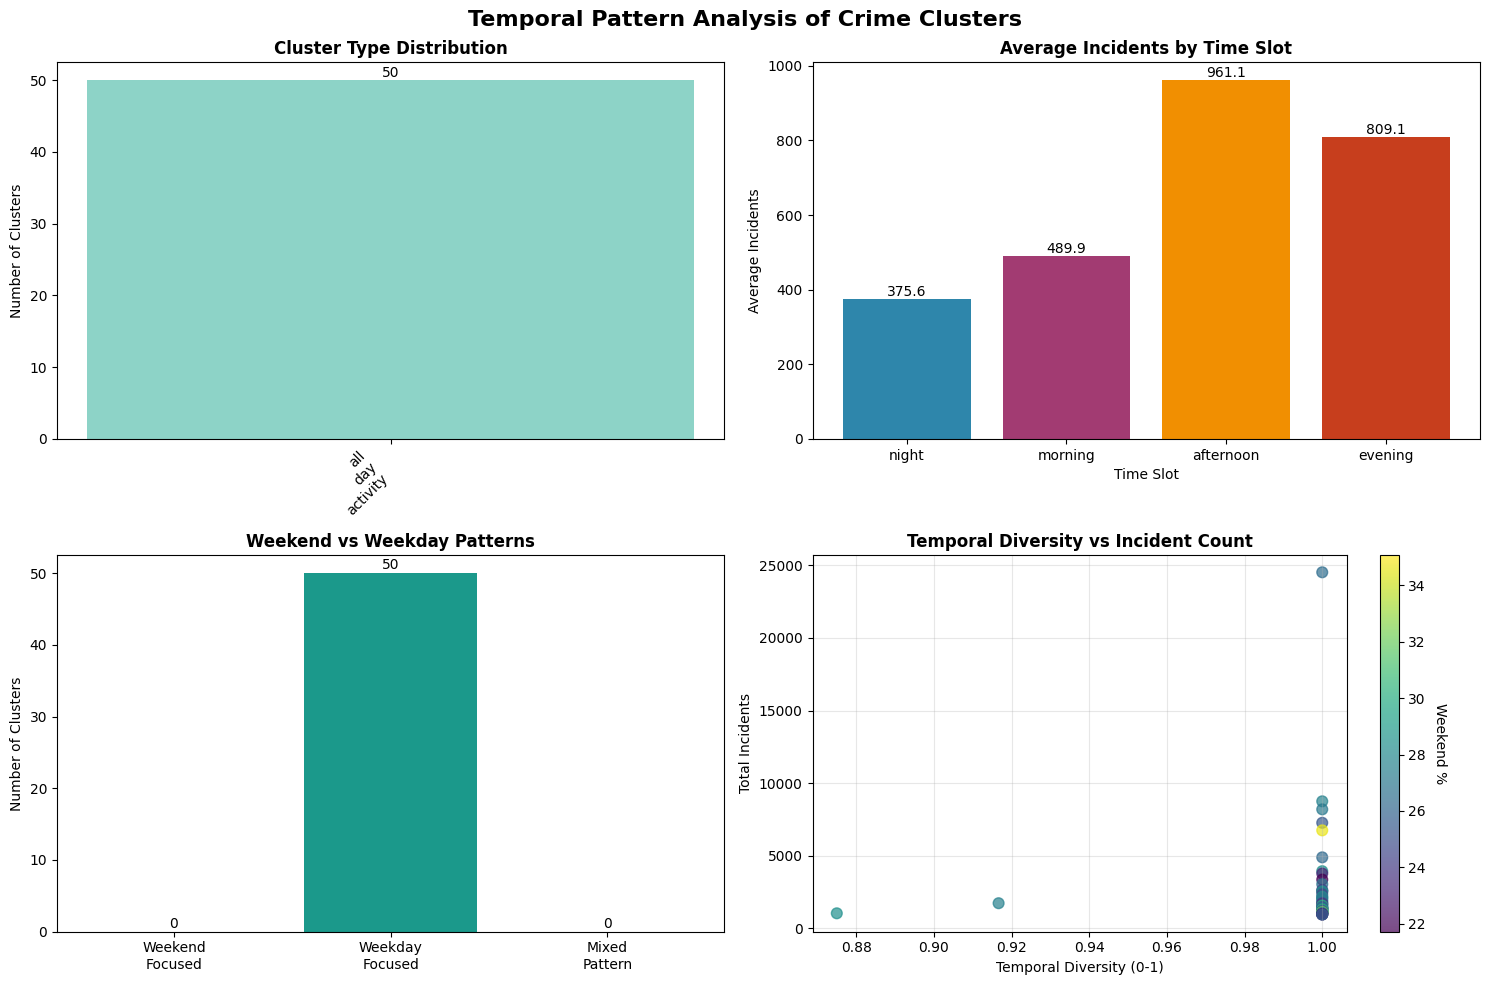

Displaying 135 clusters on map (from 10930 eligible clusters)
Interactive map created successfully!
Map saved as: cluster_temporal_patterns_map.html
Interactive map created successfully!
Map saved as: cluster_temporal_patterns_map.html


In [58]:
# --- Interactive Visualization of Temporal Patterns by Cluster ---------------

def create_temporal_pattern_map(cluster_patterns, df_labeled, top_n=100, min_incidents=10):
    """
    Create an interactive map showing clusters colored by their temporal patterns.
    """
    if cluster_patterns.empty or df_labeled.empty:
        return None
    
    # Filter clusters by minimum incidents and select diverse patterns
    filtered_patterns = cluster_patterns[cluster_patterns['total_incidents'] >= min_incidents]
    
    if filtered_patterns.empty:
        print(f"No clusters found with >= {min_incidents} incidents")
        return None
    
    # Get a diverse sample: top clusters from each pattern type
    top_clusters_list = []
    for cluster_type in filtered_patterns['cluster_type'].unique():
        type_clusters = filtered_patterns[filtered_patterns['cluster_type'] == cluster_type]
        # Take top 15 from each type to ensure diversity
        top_from_type = type_clusters.nlargest(min(15, len(type_clusters)), 'total_incidents')
        top_clusters_list.append(top_from_type)
    
    if top_clusters_list:
        diverse_clusters = pd.concat(top_clusters_list)
        # Final selection: top N overall from the diverse set
        top_clusters = diverse_clusters.nlargest(top_n, 'total_incidents')
    else:
        top_clusters = filtered_patterns.nlargest(top_n, 'total_incidents')
    
    print(f"Displaying {len(top_clusters)} clusters on map (from {len(filtered_patterns)} eligible clusters)")
    
    # Color mapping for cluster types
    type_colors = {
        'concentrated_night': '#2E86AB',
        'concentrated_morning': '#A23B72', 
        'concentrated_afternoon': '#F18F01',
        'concentrated_evening': '#C73E1D',
        'weekend_focused': '#592E83',
        'weekday_focused': '#1B998B',
        'all_day_activity': '#8D5524',
        'time_specific': '#D81159',
        'mixed_pattern': '#73A580'
    }
    
    # Calculate map center
    center_lat = top_clusters['centroid_lat'].mean()
    center_lon = top_clusters['centroid_lon'].mean()
    
    # Create base map
    m = folium.Map(
        location=[center_lat, center_lon], 
        zoom_start=10, 
        tiles="CartoDB positron"
    )
    
    # Add clusters to map grouped by type for better legend organization
    for cluster_type in top_clusters['cluster_type'].unique():
        type_clusters = top_clusters[top_clusters['cluster_type'] == cluster_type]
        color = type_colors.get(cluster_type, '#808080')
        
        # Create feature group for this cluster type
        fg = folium.FeatureGroup(name=f"{cluster_type.replace('_', ' ').title()} ({len(type_clusters)})")
        
        for _, cluster in type_clusters.iterrows():
            cluster_id = cluster['cluster_id']
            
            # Get cluster points for spatial extent
            cluster_points = df_labeled[df_labeled['cluster'] == cluster_id]
            
            if cluster_points.empty:
                continue
            
            # Create popup content
            popup_content = f"""
            <div style="width: 300px; font-family: Arial;">
                <h4 style="margin: 5px 0; color: {color};">Cluster {cluster_id}</h4>
                <hr style="margin: 8px 0;">
                <b>Type:</b> {cluster_type.replace('_', ' ').title()}<br>
                <b>Total Incidents:</b> {cluster['total_incidents']}<br>
                <b>Dominant Time:</b> {cluster['dominant_time_slot'].title()} 
                ({cluster['dominant_slot_percentage']:.1f}%)<br>
                <b>Peak Hour:</b> {cluster['peak_hour']:02d}:00<br>
                <b>Dominant Day:</b> {cluster['dominant_weekday'].title()}<br>
                <b>Weekend Activity:</b> {cluster['weekend_percentage']:.1f}%<br>
                <b>Time Diversity:</b> {cluster['temporal_diversity']:.2f}
            </div>
            """
            
            # Add spatial extent for larger clusters FIRST (so it's underneath the marker)
            if len(cluster_points) >= 5 and cluster['total_incidents'] >= 20:
                coords = cluster_points[['Latitude', 'Longitude']].values
                hull_points = MultiPoint([Point(lon, lat) for lat, lon in coords]).convex_hull
                
                if hasattr(hull_points, 'exterior'):
                    hull_coords = [[lat, lon] for lon, lat in hull_points.exterior.coords]
                    folium.Polygon(
                        locations=hull_coords,
                        color=color,
                        weight=1,
                        fillColor=color,
                        fillOpacity=0.1,  # Lower opacity to not interfere with marker
                        popup=folium.Popup(popup_content, max_width=320),  # Same popup as marker
                        tooltip=f"Cluster {cluster_id} extent - {cluster['total_incidents']} incidents"
                    ).add_to(fg)
            
            # Calculate marker size based on incidents (log scale for better visual distinction)
            marker_size = min(8 + np.log1p(cluster['total_incidents']) * 2, 25)
            
            # Add main cluster marker ON TOP (added after polygon so it's clickable)
            folium.CircleMarker(
                location=[cluster['centroid_lat'], cluster['centroid_lon']],
                radius=marker_size,
                color='black',
                weight=1,
                fillColor=color,
                fillOpacity=0.8,  # Higher opacity for marker visibility
                popup=folium.Popup(popup_content, max_width=320),
                tooltip=f"Cluster {cluster_id}: {cluster['total_incidents']} incidents"
            ).add_to(fg)
        
        fg.add_to(m)
    
    # Add layer control
    folium.LayerControl(collapsed=False).add_to(m)
    
    # Add custom legend with statistics
    legend_html = f'''
    <div style="position: fixed; 
                top: 10px; right: 10px; width: 250px; height: auto;
                background-color: white; border:2px solid grey; z-index:9999; 
                font-size:11px; padding: 10px; border-radius: 5px;">
    <h4 style="margin: 0 0 10px 0;">Temporal Crime Clusters</h4>
    <p style="margin: 5px 0; font-weight: bold;">
        Showing {len(top_clusters)} of {len(filtered_patterns)} clusters<br>
        (≥{min_incidents} incidents each)
    </p>
    <hr style="margin: 8px 0;">
    '''
    
    # Add color legend for each type present in the map
    for cluster_type in sorted(top_clusters['cluster_type'].unique()):
        color = type_colors.get(cluster_type, '#808080')
        count = len(top_clusters[top_clusters['cluster_type'] == cluster_type])
        display_name = cluster_type.replace('_', ' ').title()
        legend_html += f'''
        <p style="margin: 3px 0;">
            <span style="color: {color}; font-size: 14px;">●</span> {display_name} ({count})
        </p>
        '''
    
    legend_html += '</div>'
    m.get_root().html.add_child(folium.Element(legend_html))
    
    return m

def visualize_temporal_distributions(cluster_patterns, top_n=12):
    """
    Create visualization of temporal distributions across clusters.
    """
    if cluster_patterns.empty:
        return
    
    # Select top clusters
    top_clusters = cluster_patterns.nlargest(top_n, 'total_incidents')
    
    # Prepare data for visualization
    time_slots = ['night', 'morning', 'afternoon', 'evening']
    
    # Create subplots
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('Temporal Pattern Analysis of Crime Clusters', fontsize=16, fontweight='bold')
    
    # 1. Time slot distribution by cluster type
    ax1 = axes[0, 0]
    type_counts = top_clusters['cluster_type'].value_counts()
    colors = plt.cm.Set3(np.linspace(0, 1, len(type_counts)))
    bars = ax1.bar(range(len(type_counts)), type_counts.values, color=colors)
    ax1.set_title('Cluster Type Distribution', fontweight='bold')
    ax1.set_ylabel('Number of Clusters')
    ax1.set_xticks(range(len(type_counts)))
    ax1.set_xticklabels([t.replace('_', '\n') for t in type_counts.index], rotation=45, ha='right')
    
    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + 0.1,
                f'{int(height)}', ha='center', va='bottom')
    
    # 2. Average incidents by time slot
    ax2 = axes[0, 1]
    slot_means = [top_clusters[f'{slot}_count'].mean() for slot in time_slots]
    bars = ax2.bar(time_slots, slot_means, color=['#2E86AB', '#A23B72', '#F18F01', '#C73E1D'])
    ax2.set_title('Average Incidents by Time Slot', fontweight='bold')
    ax2.set_ylabel('Average Incidents')
    ax2.set_xlabel('Time Slot')
    
    for bar in bars:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                f'{height:.1f}', ha='center', va='bottom')
    
    # 3. Weekend vs Weekday patterns
    ax3 = axes[1, 0]
    weekend_focused = top_clusters[top_clusters['weekend_percentage'] >= 60]
    weekday_focused = top_clusters[top_clusters['weekend_percentage'] <= 40]
    mixed_pattern = top_clusters[
        (top_clusters['weekend_percentage'] > 40) & (top_clusters['weekend_percentage'] < 60)
    ]
    
    pattern_counts = [len(weekend_focused), len(weekday_focused), len(mixed_pattern)]
    pattern_labels = ['Weekend\nFocused', 'Weekday\nFocused', 'Mixed\nPattern']
    colors = ['#592E83', '#1B998B', '#73A580']
    
    bars = ax3.bar(pattern_labels, pattern_counts, color=colors)
    ax3.set_title('Weekend vs Weekday Patterns', fontweight='bold')
    ax3.set_ylabel('Number of Clusters')
    
    for bar in bars:
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2., height + 0.1,
                f'{int(height)}', ha='center', va='bottom')
    
    # 4. Temporal diversity vs incident count
    ax4 = axes[1, 1]
    scatter = ax4.scatter(
        top_clusters['temporal_diversity'], 
        top_clusters['total_incidents'],
        c=top_clusters['weekend_percentage'],
        cmap='viridis',
        s=60,
        alpha=0.7
    )
    ax4.set_title('Temporal Diversity vs Incident Count', fontweight='bold')
    ax4.set_xlabel('Temporal Diversity (0-1)')
    ax4.set_ylabel('Total Incidents')
    ax4.grid(True, alpha=0.3)
    
    # Add colorbar
    cbar = plt.colorbar(scatter, ax=ax4)
    cbar.set_label('Weekend %', rotation=270, labelpad=15)
    
    plt.tight_layout()
    plt.show()

# Create visualizations
if 'cluster_patterns' in locals() and not cluster_patterns.empty:
    print("Creating temporal pattern visualizations...")
    
    # Static visualization
    visualize_temporal_distributions(cluster_patterns, top_n=50)
    
    # Interactive map with more clusters and better filtering
    pattern_map = create_temporal_pattern_map(
        cluster_patterns, 
        df_labeled, 
        top_n=200,  # Show up to 200 clusters
        min_incidents=8  # Minimum 8 incidents per cluster
    )
    if pattern_map:
        print("Interactive map created successfully!")
        pattern_map.save("cluster_temporal_patterns_map.html")
        print("Map saved as: cluster_temporal_patterns_map.html")
        pattern_map
    else:
        print("Could not create interactive map - insufficient data")
else:
    print("No cluster patterns available for visualization")
